# Multi dimensional Log lambda Approach


relu linear neural network with discrete analysis combined with SGD

In [2]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline
import time
from joblib import Parallel, delayed
import sys
import os
sys.path.append(os.path.abspath('..'))
import simulationHawkes as sh

ModuleNotFoundError: No module named 'simulationHawkes'

# Exponential Loglikelihood

In [ ]:
def exponentialIntegratedKernel(tend,p,k):
    
    alpha1 = alpha[p,k]
    beta1 = beta[p,k]
    
    res = (alpha1/beta1)*(1-np.exp(-beta1*tend))
    
    return res

def exponentialKernel(tp,p,k):
    alpha1 = alpha[p,k]
    beta1 = beta[p,k]
    res = alpha1*np.exp(-beta1*tp)
   
    return res


    

def loglikelihood():

    
    ll=0
    integrated=0
    for p in range(0,totalD,1):
        tend = (tmax-t[p][:])
        a = np.sum(exponentialIntegratedKernel(tend.reshape(1,-1),p,p))
        
        for k in dictdimP[p]:
            tend=(tmax-t[k][:])
            a+=np.sum(exponentialIntegratedKernel(tend.reshape(1,-1),p,k))
        a+=mu[p]*tmax
        integrated+=a

        ll = ll+a
       
        ll = ll-np.log(mu[p])
       
        tp = t[p][:]  
        
        for i in range(1,len(tp),1):
            li = max(i-30,0)
            temp1 = tp[i]-tp[li:i]
            decayFactor = np.sum(exponentialKernel(temp1.reshape(1,-1),p,p))
            for k in dictdimP[p]:
                jT = mapping[p,k].get(tp[i])
                if(jT != None):
                    j = jT
                    lj = max(j-30,0)
                    temp2 = tp[i]-t[k][lj:j+1]
                    decayFactor = decayFactor + np.sum(exponentialKernel(temp2.reshape(1,-1),p,k))
            logLam = -np.log(mu[p]+decayFactor)
            ll = ll+logLam
    print("Integrated Kernel",integrated)
        
    return ll


# Kernel and Integrated Kernel

In [ ]:


def createMapAtoBIndex(a,b):
    mapAtoBIndex={}
    for x in a:
        if(max(b[b<x],default=-1)==-1):
            mapAtoBIndex[x] = None
        else:
            mapAtoBIndex[x] = (np.where(b==max(b[b<x])))[0][0]
    return mapAtoBIndex


def nnMu(x,p):
    x=(np.array([x])).reshape(-1)
    alphasMu = (AlphasMu[:,p]).reshape(-1,1)
    alpha0Mu = (Alpha0Mu[:,p])
    betasMu = (BetasMu[:,p]).reshape(-1,1)
    beta0Mu = (Beta0Mu[:,p]).reshape(-1,1)
    n1 = np.maximum(betasMu*x.reshape(1,-1) + beta0Mu,0.)
    y = np.dot(alphasMu.T,n1) + alpha0Mu

    return y.reshape(-1)


def nnKernel(x,p,j):
   
    alphas = (Alphas[:,p,j]).reshape(-1,1)
    alpha0 = (Alpha0[:,p,j])
    betas = (Betas[:,p,j]).reshape(-1,1)
    beta0 = (Beta0[:,p,j]).reshape(-1,1)
    
    n1 = np.maximum(betas*x.reshape(1,-1) + beta0,0.)
    y = np.dot(alphas.T,n1) + alpha0
    
    return y.reshape(-1)

def nnMuKernel(x,p):
    c=musC[:,p]
    kernel=0
    x_index=mapping[p,p].get(x)
    if x_index!=None:
        tk=max(0,x_index-support)
        
        temp1=x-t[p][tk:x_index+1]
        kernel+=(nnKernel(temp1,p,p)).sum()
    for j in (dictdimP[p]):
        x_index=mapping[p,j].get(x)
        if x_index!=None:
            tk=max(0,x_index-support)
            temp1=x-t[j][tk:x_index+1]
            kernel+=(nnKernel(temp1,p,j)).sum()
    lambda_x=max(nnMu(x,p)+kernel,0)+c
    
    return lambda_x

    

def inflectionPointsKernel():
    DictKernel.clear()
    for p in range(totalD):       
        for k in range(totalD):
            alphas = (Alphas[:,p,k]).reshape(-1,1)
            alpha0 = (Alpha0[:,p,k]).reshape(-1,1)
            betas = (Betas[:,p,k]).reshape(-1,1)
            beta0 = (Beta0[:,p,k]).reshape(-1,1)
            div = betas+epsilon*(np.abs(betas)<epsilon)
            x = -beta0/div
            interestX1 = x*(x>0)
   
            alwaysInclude = (x<=0)*(betas>0) #dont change
            alwaysExclude = (x<=0)*(betas<0)
    
            tempX = x*(~alwaysInclude)*(~alwaysExclude)
            interestX1 = tempX[interestX1>0]
            interestX = np.sort(interestX1)
            interestX = np.append(0,interestX)
            DictKernel[p,k]=interestX
            
                   
    return
 
def inflectionPointsMu():
    DictMu.clear()
    for p in range(totalD):
        alphasMu = (AlphasMu[:,p]).reshape(-1,1)
        alpha0Mu = (Alpha0Mu[:,p]).reshape(-1,1)
        betasMu = (BetasMu[:,p]).reshape(-1,1)
        beta0Mu = (Beta0Mu[:,p]).reshape(-1,1)
        div = betasMu+epsilon*(np.abs(betasMu)<epsilon)
        x = -beta0Mu/div
        interestX1 = x*(x>0)
   
        alwaysInclude = (x<=0)*(betasMu>0) #dont change
        alwaysExclude = (x<=0)*(betasMu<0)
    
        tempX = x*(~alwaysInclude)*(~alwaysExclude)
        interestX1 = tempX[interestX1>0]
        interestX1=interestX1[interestX1<tmax]
        interestX = np.sort(interestX1)
        interestX = np.append(0,interestX)
        DictMu[p]=interestX
    
    return
            
def nnIntegrateMuKernel(t):
    integratedValue=0
    for p in range(totalD):
        IntegratedLambda=np.array(Parallel(n_jobs=50)(delayed(nnIntegratedParallel)(j,p) for j in range(len(t[p]))),dtype=object)
        integratedValue+=IntegratedLambda.sum()
        print(integratedValue)
    return integratedValue

def nnIntegratedParallel(x,p):
    c=musC[:,p]
    inflectionKernel=[[]for j in range(totalD)]
    temp=[[]for j in range(totalD)]
    for k in range(totalD):
        inflectionKernel[k]=DictKernel[p,k]
    inflectionMu=DictMu[p]
    tj=t[p][x]
    if tj>0:
        iP=t[p][x-1]
        lj=max(0,x-support)
        temp[p]=t[p][lj:x]
        otherp=dictdimP[p]
        for k in otherp:
            iPlimit=mapping[p,k].get(tj)
            if iPlimit!=None:
                lj2=max(0,iPlimit-support)
                temp[k]=t[k][lj2:iPlimit+1]
        inflectionPs=inflectionMu
        for d in range(totalD):
            if len(temp[d])>0:
                inflection1Ps=inflectionKernel[d]+(temp[d]).reshape(-1,1)
                inflectionPs=np.concatenate((inflection1Ps.reshape(-1),inflectionPs))
                inflectionPs=inflectionPs[(inflectionPs>iP)*(inflectionPs<tj)]
                inflectionPs=np.sort(inflectionPs)
        inflectionPs=np.append(iP,inflectionPs)
        inflectionPs=np.append(inflectionPs,tj)
        IntegratedLambda=nnIntegrateMuKernelPart(temp,p,inflectionPs)+c*(tj-iP)
    else:
        IntegratedLambda=0
    return IntegratedLambda



def nnIntegrateMuKernelPart(temp,p,inflectionPs):
    integral=0
    inflectionMu=DictMu[p]
    
    alphasMu = (AlphasMu[:,p]).reshape(-1,1)
    alpha0Mu = (Alpha0Mu[:,p]).reshape(-1,1)
    betasMu = (BetasMu[:,p]).reshape(-1,1)
    beta0Mu = (Beta0Mu[:,p]).reshape(-1,1)
    c=musC[:,p]
    
    alphas=[[] for i in range(totalD)]
    alpha0=[[] for i in range(totalD)]
    betas=[[] for i in range(totalD)]
    beta0=[[] for i in range(totalD)]
    inflectionKernel=[[]for i in range(totalD)]
    for k in range(totalD):
        inflectionKernel[k]=DictKernel[p,k]
    
        alphas[k] = (Alphas[:,p,k]).reshape(-1,1)
        alpha0[k] = (Alpha0[:,p,k]).reshape(-1,1)
        betas[k] = (Betas[:,p,k]).reshape(-1,1)
        beta0[k] = (Beta0[:,p,k]).reshape(-1,1)
    
    
    lambdaValInfl=lambdaVs(p,temp,inflectionPs)
    
    if len(lambdaValInfl<=0)!=0:
        oIp=[]
        oIp.append(inflectionPs[0])
        for j in range(1,len(inflectionPs)):
            if ((lambdaValInfl[j]<=0) and (lambdaValInfl[j-1]>0)) or ((lambdaValInfl[j]>0) and (lambdaValInfl[j-1]<=0)):
                if (oIp[-1]==inflectionPs[j-1]):
                    oIp.append(inflectionPs[j])
                else:
                    oIp.append(inflectionPs[j-1])
                    oIp.append(inflectionPs[j])
        oIp=np.array(oIp)
        outerInflections=outerIps(p,temp,oIp)
        if len(outerInflections)!=0:
            inflectionPs=np.concatenate((inflectionPs,outerInflections))
            inflectionPs=np.sort(inflectionPs)
    
    for i in range(1,len(inflectionPs)):
        iP1=inflectionPs[i]
        iP2=inflectionPs[i-1]
        Mn1=np.maximum(betasMu*(iP1-epsilon)+beta0Mu,0)
        Mdn1=(Mn1>0)
        Mn2=(alphasMu*Mn1).sum()+alpha0Mu
        
        n22=0
        dn1=[[]for j in range(totalD)]
        for k in range(totalD):
            temp1=iP1-temp[k]
            temp1=temp1[temp1>0]
            n1=np.maximum(betas[k]*(temp1-epsilon).reshape(1,-1)+beta0[k],0)
            dn1[k]=(n1>0)
            n2=(np.dot(alphas[k].T,n1)+alpha0[k]).sum()
            n22+=n2
        
        
        dn2=((Mn2+n22)>0)
        if dn2!=0:
        
            term1Mu=(alphasMu*iP1*((betasMu*iP1*0.5)+beta0Mu)*Mdn1).sum()+alpha0Mu*iP1
            term2Mu=(alphasMu*iP2*((betasMu*iP2*0.5)+beta0Mu)*Mdn1).sum()+alpha0Mu*iP2
            term1Kernel=term2Kernel=0
            for k in range(len(t)):
                temp1=(iP1-temp[k]).reshape(1,-1)
                temp2=(iP2-temp[k]).reshape(1,-1)
                temp1=temp1[temp1>0]
                temp2=temp2[temp2>=0]
                dn11=dn1[k][:,0:len(temp1)]
                dn12=dn1[k][:,0:len(temp2)]
                term1Kernel+=(alpha0[k]*temp1+np.sum(alphas[k]*temp1*(beta0[k]+0.5*temp1*betas[k])*dn11,axis=0)).sum()
                term2Kernel+=(alpha0[k]*temp2+np.sum(alphas[k]*temp2*(beta0[k]+0.5*temp2*betas[k])*dn12,axis=0)).sum()
        
            integral+=(term1Mu+ term1Kernel-(term2Mu+ term2Kernel)).sum()
     
            
    return integral


def lambdaVs(p,temp,inflectionPs):

    c=musC[:,p]
    y=0
    for k in range(totalD):
        
        inflectionKernel=DictKernel[p,k]
        alphas = (Alphas[:,p,k]).reshape(-1,1)
        alpha0 = (Alpha0[:,p,k]).reshape(-1,1)
        betas = (Betas[:,p,k]).reshape(-1,1)
        beta0 = (Beta0[:,p,k]).reshape(-1,1)
        if len(temp[k])!=0:
            temp1=inflectionPs.reshape(-1,1)-temp[k]
            temp2=(temp1<0)+Bn
            temp2=temp2*(temp2>Bn)+temp1
            n1=np.maximum(betas*(temp2).reshape(1,-1)+beta0,0)
            n2=np.sum(alphas*n1,axis=0)+alpha0
            n2=n2.reshape(len(inflectionPs),len(temp[k]))
            y+=np.sum(n2,axis=1)
    
    y=y+nnMu(inflectionPs,p)+c
 
    return y



def outerIps(p,temp,inflectionPs):        
    
    alphasMu = (AlphasMu[:,p]).reshape(-1,1)
    alpha0Mu = (Alpha0Mu[:,p]).reshape(-1,1)
    betasMu = (BetasMu[:,p]).reshape(-1,1)
    beta0Mu = (Beta0Mu[:,p]).reshape(-1,1)
    
    c=musC[:,p]
    inflection=[]
    infl1=-100
    
    for j in range(1,len(inflectionPs)):
        iP1=inflectionPs[j]
        iP2=inflectionPs[j-1]
        Mn1=betasMu*(iP1-epsilon)+beta0Mu
        Mdn1=(Mn1>0)
        v1=-alpha0Mu-(alphasMu*beta0Mu*Mdn1).sum()
        v2=(alphasMu*betasMu*Mdn1).sum()
        
        v3=v4=0
        for k in range(totalD):
            alphas = (Alphas[:,p,k]).reshape(-1,1)
            alpha0 = (Alpha0[:,p,k])
            betas = (Betas[:,p,k]).reshape(-1,1)
            beta0 = (Beta0[:,p,k]).reshape(-1,1)
            if len(temp[k])!=0:
                temp1=iP1-temp[k]
                temp1=temp1[temp1>0]
                n1=betas*(temp1-epsilon).reshape(1,-1)+beta0
                dn1=(n1>0)
           
                v3+=-len(temp1)*alpha0-(alphas*beta0*dn1).sum()+(alphas*betas*dn1*(temp1).reshape(1,-1)).sum()
                v4+=(alphas*betas*dn1).sum()
        
        infl=(v1+v3)/(v2+v4)
        if (iP1>infl) & (iP2<infl) &(infl1!=infl):
            infl1=infl
            inflection.append(infl)
    return (np.array(inflection)).reshape(-1)


def nnLoglikelihoodCom(t):
    ll=0
    start=time.time()
    llIn=(nnIntegrateMuKernel(t)).sum()
    end=time.time()
    #print("time taken for integrated kernel",end-start)
    print("Integrated Part Mu and kernel ",llIn)
    ll=ll+llIn
    for p in range(totalD):
        tp=t[p]
        for j in range(len(tp)):
            tpj=tp[j]
            MuKernel=(nnMuKernel(tpj,p)).sum()
            logLam = -np.log(MuKernel)
            ll = ll+logLam
           
        
    print("log Part",ll-llIn)
    return ll






# Gradient Calculation

In [ ]:
#Mu and Kernel combined Gradients
def gradientsMuKernel(iArray):
    alphasMu=(AlphasMu[:,0]).reshape(-1,1)
    alphas=(Alphas[:,0,0]).reshape(-1,1)
    d=len(t)
    gradAMu=np.zeros((len(alphasMu),d))*0
    gradBMu=np.zeros((len(alphasMu),d))*0
    gradB0Mu=np.zeros((len(alphasMu),d))*0
    gradA0Mu=np.zeros((1,d))*0
    
    gradA=np.zeros((len(alphas),d,d))*0
    gradB=np.zeros((len(alphas),d,d))*0
    gradB0=np.zeros((len(alphas),d,d))*0
    gradA0=np.zeros((1,d,d))*0
    gradC=0

    start=time.time()
    
    gradients=np.array(Parallel(n_jobs=50)(delayed(gradientsMuKernelParallel)(j,iArray) for j in range(len(iArray[1,:]))),dtype=object)
    #print(gradients[:,4])
    gradAMu+=(gradients[:,0]).sum()
    gradA0Mu+=(gradients[:,1]).sum()
    gradBMu+=(gradients[:,2]).sum()
    gradB0Mu+=(gradients[:,3]).sum()
        
    gradA+=(gradients[:,4]).sum()
    gradA0+=(gradients[:,5]).sum()
    gradB+=(gradients[:,6]).sum()
    gradB0+=(gradients[:,7]).sum()
    gradC+=(gradients[:,8]).sum()
    
    length=len(iArray)
        
    gradAMu,gradA0Mu,gradBMu,gradB0Mu=gradAMu/length,gradA0Mu/length,gradBMu/length,gradB0Mu/length
    gradA,gradA0,gradB,gradB0=gradA/length,gradA0/length,gradB/length,gradB0/length
    
    end=time.time()
    #print("for gradient calculation",end-start)
    gradAMu=gradAMu.astype('float32')
    gradA0Mu=gradA0Mu.astype('float32')
    gradBMu=gradBMu.astype('float32')
    gradB0Mu=gradB0Mu.astype('float32')

    gradC  = gradC/length
    
    gradA = gradA.astype('float32')
    gradA0 = gradA0.astype('float32')
    gradB = gradB.astype('float32')
    gradB0 = gradB0.astype('float32')
    gradC=gradC.astype('float32')
    
    return gradAMu,gradA0Mu,gradBMu,gradB0Mu, gradA,gradA0*0,gradB,gradB0, gradC

def gradientsMuKernelParallel(j,iArray):
    d=(iArray[0,j]).astype(int)
    alphasMu1=AlphasMu[:,d]
    alphas1=Alphas[:,d,d]
    totalD=len(t)
    gradAMu=np.zeros((len(alphasMu1),totalD))*0
    gradBMu=np.zeros((len(alphasMu1),totalD))*0
    gradB0Mu=np.zeros((len(alphasMu1),totalD))*0
    gradA0Mu=np.zeros((1,totalD))*0
    
    gradA=np.zeros((len(alphas1),totalD,totalD))*0
    gradB=np.zeros((len(alphas1),totalD,totalD))*0
    gradB0=np.zeros((len(alphas1),totalD,totalD))*0
    gradA0=np.zeros((1,totalD,totalD))*0
    gradC=np.zeros((1,totalD))*0
    
    alphasMu = (AlphasMu[:,d]).reshape(-1,1)
    alpha0Mu = (Alpha0Mu[:,d]).reshape(-1,1)
    betasMu = (BetasMu[:,d]).reshape(-1,1)
    beta0Mu = (Beta0Mu[:,d]).reshape(-1,1)
    c=musC[:,d]
    inflectionMu=DictMu[d]
    temp=[[]for k in range(totalD)]
    index=(iArray[1,j]).astype(int)
    tj=t[d][index]    
    if tj>0:
        inflectionPs=inflectionMu
        iP=t[d][index-1]
        
        for k in range(len(t)):
            inflectionKernel=DictKernel[d,k]
            lj1=mapping[d,k].get(tj)
            if lj1!=None:
                lj=max(0,lj1-support)
                temp1=t[k][lj:lj1+1]     
                temp[k] = temp1
            inflectionP1=inflectionKernel+temp1.reshape(-1,1)
            inflectionPs=np.concatenate((inflectionP1.reshape(-1),inflectionPs))
            inflectionPs=inflectionPs[(inflectionPs>iP)*(inflectionPs<tj)]        
            inflectionPs=np.sort(inflectionPs)
                
        
        inflectionPs=np.append(iP,inflectionPs)
        inflectionPs=np.append(inflectionPs,tj)
        gradMu,gradKer,gradCn=gradientsMuKernelPart(tj,iP,inflectionPs,temp,d)
        gradAMu=gradMu[0]
        gradA0Mu=gradMu[1]
        gradBMu=gradMu[2]
        gradB0Mu=gradMu[3]
        
        gradA=gradKer[0]
        gradA0=gradKer[1]
        gradB=gradKer[2]
        gradB0=gradKer[3]
        
        gradC=gradCn
        logPart=sum(nnMuKernel(tj,d))
        inverseLog=1/logPart
        Mn1=np.maximum(betasMu*(tj-epsilon)+beta0Mu,0)
        Mdn1=(Mn1>0)
        Mn2=(alphasMu*Mn1).sum()+alpha0Mu
        otherd=dictdimP[d]
        
        n2=0
        dn1=[[]for j in range(totalD)]
        temp.clear()
        temp=[[]for k in range(totalD)]
        for k in range(totalD):
            alphas = (Alphas[:,d,k]).reshape(-1,1)
            alpha0 = (Alpha0[:,d,k]).reshape(-1,1)
            betas = (Betas[:,d,k]).reshape(-1,1)
            beta0 = (Beta0[:,d,k]).reshape(-1,1)
            lj1=mapping[d,k].get(tj)
            if lj1!=None:
                lj=max(0,lj1-support)
                temp1=t[k][lj:lj1+1]
                temp[k]=temp1
                
                n1=np.maximum(betas*(tj-temp1-epsilon).reshape(1,-1)+beta0,0)
                dn1[k]=(n1>0)
                n21=(np.dot(alphas.T,n1)+alpha0[0]).sum()
                n2+=n21
        
        dn2=((n2+Mn2).sum()>0)
        if dn2!=0:
            newMn1=np.maximum(betasMu*(tj)+beta0Mu,0)
            gradAMu[:,d]=gradAMu[:,d]-((newMn1)*Mdn1*inverseLog).reshape(-1)
            gradA0Mu[:,d]=gradA0Mu[:,d]-1*inverseLog
            gradBMu[:,d]=gradBMu[:,d]-((alphasMu*tj*Mdn1)*inverseLog).reshape(-1)
            gradB0Mu[:,d]=gradB0Mu[:,d]-((alphasMu*Mdn1)*inverseLog).reshape(-1)
            
            for k in range(len(t)):
                alphas = (Alphas[:,d,k]).reshape(-1,1)
                alpha0 = (Alpha0[:,d,k]).reshape(-1,1)
                betas = (Betas[:,d,k]).reshape(-1,1)
                beta0 = (Beta0[:,d,k]).reshape(-1,1)
                gradA0[:,d,k]=gradA0[:,d,k]-(len(temp[k]))*inverseLog
                n1=np.maximum(betas*(tj-temp[k]).reshape(1,-1)+beta0,0)
                gradA[:,d,k]=gradA[:,d,k]-(np.sum(n1*dn1[k],axis=1)*inverseLog).reshape(-1)
                gradB[:,d,k]=gradB[:,d,k]-(np.sum(alphas*(tj-temp[k]).reshape(1,-1)*dn1[k],axis=1)*inverseLog).reshape(-1)
                gradB0[:,d,k]=gradB0[:,d,k]-(np.sum(alphas*dn1[k],axis=1)*inverseLog).reshape(-1)
               
        gradC[:,d]=gradC[:,d]-(1*inverseLog)
    else:
        gradAMu=gradBMu=gradB0Mu=np.zeros((len(alphasMu1),totalD))*0
        gradA=gradB=gradB0=np.zeros((len(alphas1),totalD,totalD))*0
        gradA0Mu=gradC=np.zeros((1,totalD))*0
        gradA0=np.zeros((1,totalD,totalD))*0
        
    return gradAMu,gradA0Mu,gradBMu,gradB0Mu,gradA,gradA0*0,gradB,gradB0,gradC
        

            

def gradientsMuKernelPart(tj,iP,inflectionPs,temp,d):
    totalD=len(t)
    alphasMu = (AlphasMu[:,d]).reshape(-1,1)
    alpha0Mu = (Alpha0Mu[:,d]).reshape(-1,1)
    betasMu = (BetasMu[:,d]).reshape(-1,1)
    beta0Mu = (Beta0Mu[:,d]).reshape(-1,1)
    c=musC[:,d]
    inflectionMu=DictMu[d]
    lambdaValInfl=lambdaVs(d,temp,inflectionPs)            
    if len(lambdaValInfl<=0)!=0:
        oIp=[]
        oIp.append(inflectionPs[0])
        for j in range(1,len(inflectionPs)):
            if ((lambdaValInfl[j]<=0) and (lambdaValInfl[j-1]>0)) or ((lambdaValInfl[j]>0) and (lambdaValInfl[j-1]<=0)):
                if (oIp[-1]==inflectionPs[j-1]):
                    oIp.append(inflectionPs[j])
                else:
                    oIp.append(inflectionPs[j-1])
                    oIp.append(inflectionPs[j])
        oIp=np.array(oIp)
        outerInflections=outerIps(d,temp,oIp)
        if len(outerInflections)!=0:
            inflectionPs=np.concatenate((inflectionPs,outerInflections))
            inflectionPs=np.sort(inflectionPs)
    gradAMu=np.zeros((len(alphasMu), totalD))*0
    gradBMu=np.zeros((len(alphasMu), totalD))*0
    gradB0Mu=np.zeros((len(alphasMu),totalD))*0
    gradA0Mu=np.zeros((1,totalD))*0
    gradC=np.zeros((1,totalD))*0
    
    gradA=np.zeros((len(Alphas[:,0,0]), totalD, totalD))*0
    gradB=np.zeros((len(Alphas[:,0,0]), totalD, totalD))*0
    gradB0=np.zeros((len(Alphas[:,0,0]),totalD, totalD))*0
    gradA0=np.zeros((1,totalD, totalD))*0
    
    for j in range(1,len(inflectionPs)):
        iP1=inflectionPs[j]
        iP2=inflectionPs[j-1]
        Mn1=np.maximum(betasMu*(iP1-epsilon)+beta0Mu,0)
        Mdn1=(Mn1>0)
        Mn2=(alphasMu*Mn1).sum()+alpha0Mu[0]
        
        dn1=[[] for i in range(len(t)) ]
        n2=0
        for k in range(len(t)):
            alphas = (Alphas[:,d,k]).reshape(-1,1)
            alpha0 = (Alpha0[:,d,k]).reshape(-1,1)
            betas = (Betas[:,d,k]).reshape(-1,1)
            beta0 = (Beta0[:,d,k]).reshape(-1,1)
            temp1=iP1-temp[k]
            temp1=temp1[temp1>0]
            n1=np.maximum(betas*(temp1-epsilon).reshape(1,-1)+beta0,0)
            dn1[k]=(n1>0)
            
            n21=(np.dot(alphas.T,n1)+alpha0[0]).sum()
            n2+=n21
        dn2=((Mn2+n2)>0)
        
        
        if dn2!=0:
            cn1=iP1*(0.5*betasMu*iP1+beta0Mu)*Mdn1
            cn2=iP2*(0.5*betasMu*iP2+beta0Mu)*Mdn1
        
    
            gradAMu[:,d]=gradAMu[:,d]+(cn1-cn2).reshape(-1)
            gradA0Mu[:,d]=gradA0Mu[:,d]+(iP1-iP2)
            gradBMu[:,d]=gradBMu[:,d]+(0.5*alphasMu*Mdn1*(iP1**2-iP2**2)).reshape(-1)
            gradB0Mu[:,d]=gradB0Mu[:,d]+(alphasMu*Mdn1*(iP1-iP2)).reshape(-1)
            
            for k in range(len(t)):
                alphas = (Alphas[:,d,k]).reshape(-1,1)
                alpha0 = (Alpha0[:,d,k]).reshape(-1,1)
                betas = (Betas[:,d,k]).reshape(-1,1)
                beta0 = (Beta0[:,d,k]).reshape(-1,1)
                
                temp1=(iP1-temp[k]).reshape(1,-1)
                temp2=(iP2-temp[k]).reshape(1,-1)
                temp1=temp1[temp1>0]
                temp2=temp2[temp2>=0]
                dn11=dn1[k][:,0:len(temp1)]
                dn12=dn1[k][:,0:len(temp2)]
                ck1=(np.sum(temp1*(beta0+0.5*betas*temp1)*dn11,axis=1)).reshape(-1,1)
                ck2=(np.sum(temp2*(beta0+0.5*betas*temp2)*dn12,axis=1)).reshape(-1,1)
                
                   
                gradA[:,d,k]=gradA[:,d,k]+ (ck1-ck2).reshape(-1)
                #print("temps",temp1,temp2,iP1,iP2,tj,iP)
                
                gradA0[:,d,k]=gradA0[:,d,k]+len(temp2)*(iP1-iP2)
                gradB[:,d,k]=gradB[:,d,k]+(np.sum(alphas*0.5*(temp1)**2*dn11,axis=1)-np.sum(alphas*0.5*(temp2)**2*dn12,axis=1)).reshape(-1)
                gradB0[:,d,k]=gradB0[:,d,k]+(np.sum(alphas*temp1*dn11,axis=1)-np.sum(alphas*temp2*dn12,axis=1)).reshape(-1)
                
        gradC[:,d] = gradC[:,d]+(iP1-iP2)
    gradMu=[gradAMu,gradA0Mu,gradBMu,gradB0Mu]
    gradKer=[gradA,gradA0,gradB,gradB0]
    
    return gradMu,gradKer,gradC
    

#  plots

In [ ]:
def plottingKernels(p,k,tk):
    if specialcase==1:
        res= special_y_values[p][k]
                
    else:
        if types[p][k]=='exp':
            alpha1=kernels[p][k][0]
            beta1=kernels[p][k][1]
            res = alpha1*np.exp(-beta1*tk)
        elif types[p][k]=='neg':
            alpha1=kernels[p][k][0]
            beta1=kernels[p][k][1]
            res = -alpha1*np.exp(-beta1*tk)
        elif types[p][k]=='rect':
            alpha1=kernels[p][k][0]
            beta1=kernels[p][k][1]
            delta1=kernels[p][k][2]
            res =alpha1*beta1*((delta1<tk)*((delta1+1/beta1)>tk))
    return res

def plotLambdas():
    
    plotrange=20
    dx=0.01

    for p in range(totalD):
        c=musC[:,p]
        tp=t[p]
        lambda_value=[]
        time_intervals=[]
        lambda_nn=[]
        for j in range(1,plotrange):
            
            
            new_temp=np.linspace(tp[j-1],tp[j],20)
            decayfactor=np.zeros(len(new_temp))
            decayfactornn=np.zeros(len(new_temp))
            li=max(0,j-support)
            temp=new_temp.reshape(-1,1)-tp[li:j]
            
            for k1 in range(len(temp)):
                decayfactor[k1]+=np.sum(plottingKernels(p,p,temp[k1]))
                decayfactornn[k1]+=np.sum(nnKernel(temp[k1],p,p))
            for k in  dictdimP[p]:
                jt=mapping[p,k].get(tp[j])
                if jt!=None:
                    ti=max(0,jt-support)
                    temp2=new_temp.reshape(-1,1)-t[k][ti:jt+1]
                    
                    for k1 in range(len(temp2)):
                        temp2s=temp2[k1][temp2[k1]>0]
                        decayfactor[k1]+=np.sum(plottingKernels(p,k,temp2s))
                        decayfactornn[k1]+=np.sum(nnKernel(temp2s,p,k))
                        
                    
            lambda1=np.maximum(mu[p]+decayfactor,0)
            lambdann1=np.maximum(nnMu(new_temp,p)+decayfactornn,0)+c
            lambda_value.append(lambda1)
            lambda_nn.append(lambdann1)
            time_intervals.append(new_temp)
        time_intervals=(np.array(time_intervals)).reshape(-1)
        lambda_value=(np.array(lambda_value)).reshape(-1)
        lambda_nn=(np.array(lambda_nn)).reshape(-1)
        plt.figure(figsize=(10,4))
        plt.title(str(p)+"th dimension")
        
        plt.plot(time_intervals,lambda_value,label="Real Intensity")
        plt.plot(time_intervals,lambda_nn,label="NNNH")
        plt.xlabel("t")
        plt.ylabel("$\lambda(t)$")
        plt.legend()
        plt.grid()
        plt.pause(0.005)
    return

def plotKernels():
    dx=0.01
    tk = np.arange(0,5,dx)
    y1 = np.zeros([len(tk),totalD,totalD])
    y2 = np.zeros([len(tk),totalD,totalD])
    fig, ax = plt.subplots(totalD, totalD,sharex=True,sharey=True,figsize=(15,15))
    
    for p in range(totalD):
        for k in range(totalD):
            if specialcase==1:
                ax[p][k].plot(special_t_values[p][k],special_y_values[p][k],'tab:blue')
                
            else:
                if types[p][k]=='exp':
                    alpha1=kernels[p][k][0]
                    beta1=kernels[p][k][1]
                    y1[:,p,k] = alpha1*np.exp(-beta1*tk)
                elif types[p][k]=='neg':
                    alpha1=kernels[p][k][0]
                    beta1=kernels[p][k][1]
                    y1[:,p,k] = -alpha1*np.exp(-beta1*tk)
                elif types[p][k]=='rect':
                    alpha1=kernels[p][k][0]
                    beta1=kernels[p][k][1]
                    delta1=kernels[p][k][2]
                    y1[:,p,k] =alpha1*beta1*((delta1<tk)*((delta1+1/beta1)>tk))
                
                ax[p][k].plot(tk.reshape(-1), y1[:,p,k],'tab:blue')
            y2[:,p,k] = nnKernel(tk,p,k)
            ax[p][k].plot(tk.reshape(-1),y2[:,p,k],'tab:orange')
            ax[p][k].set_title(r"$\phi_{%g,%g}(t)$" %(p,k))
            #ax[p][k].set_ylim(y2[0,p,k],y2[,p,k])
    
    plt.tight_layout()
    plt.pause(0.005)
    return

def plotMus():
   
    dx=0.01
    tk = np.arange(0,tmax,1)
    y1 = np.zeros([len(tk),totalD])
    y2 = np.zeros([len(tk),totalD])
    fig, ax = plt.subplots(totalD,1,sharex=True,sharey=True,figsize=(15,15))
    
    for p in range(totalD):
        y1[:,p] = np.ones(len(tk))*mu[p]
        y2[:,p] = nnMu(tk,p)
        ax[p].plot(tk.reshape(-1), y1[:,p],'tab:blue')
        ax[p].plot(tk.reshape(-1),y2[:,p],'tab:orange')
        ax[p].set_ylabel(r"$\mu_{%g}(t)$" % (p))
        #ax[p].set_ylim(y2[0,p],y2[-1,p])
    plt.tight_layout()
    plt.pause(0.005)
    return




# Simulation multivarite Hawkes 

In [4]:


def exponentialKernel1(tp,p,k):
    alpha1 = alpha[p,k]
    beta1 = beta[p,k]
    res = alpha1*np.exp(-beta1*tp)
   
    return res
def multiSimHawkes(alpha,beta,mu,T):
    support=30
    totalD=len(mu)
    timesteps=[[] for d in range(totalD)]
    #for d in range(totalD):
    #    timesteps[d].append(0)
    tmax=0
    while tmax<T:
        lambda1=np.zeros(totalD)
        
        for d in range(totalD):
            lambda1[d]=mu[d]
            for k in range(totalD):
                if len(timesteps[k])!=0:
                    temp=tmax-np.array(timesteps[k][-support:])
                    temp=temp[temp>=0]
                    lambda1[d]+=exponentialKernel1(temp,d,k).sum()        
        totalLambda=lambda1.sum()
        u=np.random.uniform(0,1,1)[0]
        intArr=-np.log(u)/totalLambda
        
        tmax=tmax+intArr
        u=np.random.uniform(0,1,1)[0]
        lambdaTmax=np.zeros(totalD)
        for d in range(totalD):
            lambdaTmax[d]=mu[d]
            for k in range(totalD):
                if len(timesteps[k])!=0:
                    temp=tmax-np.array(timesteps[k][-support:])
                    temp=temp[temp>0]
                    lambdaTmax[d]+=exponentialKernel1(temp,d,k).sum()
            if totalLambda*u<=lambdaTmax.sum():
                timesteps[d].append(tmax)
                
                break
    return timesteps

n_nodes=2
alpha=np.ones((n_nodes,n_nodes))*0
beta=np.ones((n_nodes,n_nodes))*3
mu=np.ones(n_nodes)*0.3
alpha[0,1]=0.3
#alpha[1,1]=0
run_time=1000

t=multiSimHawkes(alpha,beta,mu,run_time)


print(alpha,beta,mu)
types=[['exp','rect'],['neg','exp']]
kernels=[[[0.20,3],[0.7,0.3,1]],[[0.2,3],[0.2,3]]]
mu=[0.3,0.3]
runtime=3000

t=sh.multiSimHawkesAll(mu,runtime,types,kernels)

[[0.  0.3]
 [0.  0. ]] [[3. 3.]
 [3. 3.]] [0.3 0.3]


NameError: name 'sh' is not defined

# Intialization

In [ ]:





def initializeParamsKernel(nNeurons,fac):
    for p in range(totalD):
        for k in range(totalD):
            Alphas[:,p,k]=np.random.uniform(0,1,nNeurons)*0.2
            Alpha0[:,p,k]=np.random.uniform(0,1,1)*0
            Betas[:,p,k]=np.random.uniform(0,1,nNeurons)*-0.3
            Beta0[:,p,k]=np.random.uniform(0,1,nNeurons)*0.3

    return

def initializeParamsMu(nNeurons1,fac):
    for p in range(totalD):
        AlphasMu[:,p]=np.random.uniform(0,1,nNeurons1)*0.2
        Alpha0Mu[:,p]=np.random.uniform(0,1,1)*0.001
        
        betas1=(np.random.uniform(0,1,int(nNeurons1/2)))*0.001
        betas2=(np.random.uniform(-1,0,int(nNeurons1/2)))*0.001
        BetasMu[:,p]=np.concatenate((betas1,betas2))
        
        beta01=(np.random.uniform(-1,0,int(nNeurons1/2)))
        beta02=(np.random.uniform(0,1,int(nNeurons1/2)))
        Beta0Mu[:,p]=np.concatenate((beta01,beta02))
        
        BetasMu[:,p]=BetasMu[:,p]*(len(t[p])/tmax)
        
        AlphasMu[:,p]=AlphasMu[:,p]*0
        Alpha0Mu[:,p]=(len(t[p])/tmax)
        BetasMu[:,p]=BetasMu[:,p]*0
        Beta0Mu[:,p]=Beta0Mu[:,p]*0
        
        
        musC[:,p]=np.random.uniform(0,1,1)*1e-5
   
    return

        
    
def sgdNeuralHawkesBiVariate(nEpochs,lr,lrmu):
    
    
    np.random.seed(seed=None)
    global Alpha0
    global Alphas
    global Betas
    global Beta0
    global AlphasMu, Alpha0Mu, BetasMu, Beta0Mu, musC
    
    lr2 =lr*0.1
    lrmu2 = lrmu*1e-3
    beta_1 = 0.9
    beta_2 =0.999
  
    
    bestll = 1e8
    errorList=[]
    
    optimalParams = list([Alpha0,Alphas,Betas,Beta0,AlphasMu,Alpha0Mu,BetasMu,Beta0Mu,musC])
    m_t_A = np.zeros([nNeurons,totalD,totalD])
    m_t_A0 =np.zeros([1,totalD,totalD])
    m_t_B= np.zeros([nNeurons,totalD,totalD])
    m_t_B0= np.zeros([nNeurons,totalD,totalD])
    
    m_t_AMu = np.zeros([nNeurons1,totalD])
    m_t_A0Mu=m_t_C =np.zeros([1,totalD])
    m_t_BMu= np.zeros([nNeurons1,totalD])
    m_t_B0Mu= np.zeros([nNeurons1,totalD])
    
    v_t_A = np.zeros([nNeurons,totalD,totalD])
    v_t_A0 =np.zeros([1,totalD,totalD])
    v_t_B= np.zeros([nNeurons,totalD,totalD])
    v_t_B0= np.zeros([nNeurons,totalD,totalD])
    
    v_t_AMu = np.zeros([nNeurons1,totalD])
    v_t_A0Mu =v_t_C=np.zeros([1,totalD])
    v_t_BMu= np.zeros([nNeurons1,totalD])
    v_t_B0Mu= np.zeros([nNeurons1,totalD])
    
    count = 0
    totalLength=0
    for j in range(len(t)):
        totalLength+=len(t[j])
    tCompressed=np.zeros((2,totalLength))
    length=0
    for j in range(len(t)):
        length1=length
        length+=len(t[j])
        tCompressed[0,length1:length]=j
        tCompressed[1,length1:length]=np.arange(0,length-length1,1)
    print(totalLength,"number of timepoints")
    inflectionPointsKernel()
    inflectionPointsMu()
    bsize = max(int(totalLength/100),100)
    #error=nnLoglikelihoodCom(t)
    #print("Starting LogLik", error)    
    for epochs in range(nEpochs):
        rsample = np.random.choice(totalLength,totalLength,replace = False)
        
        for i in range(0,len(rsample),bsize):
            count=count+1 
            grad = gradientsMuKernel(tCompressed[:,rsample[i:i+bsize]])
            
            #print("Gradient fr Mu:" ,grad[1])
            m_t_A0Mu = beta_1*m_t_A0Mu + (1-beta_1)*grad[1]
            v_t_A0Mu = beta_2*v_t_A0Mu + (1-beta_2)*(grad[1]*grad[1])
            m_cap_A0Mu = m_t_A0Mu/(1-(beta_1**count))
            v_cap_A0Mu = v_t_A0Mu/(1-(beta_2**count))
            Alpha0Mu = Alpha0Mu-(lrmu*m_cap_A0Mu)/(np.sqrt(v_cap_A0Mu)+epsilon) 
                         
                   
            m_t_AMu = beta_1*m_t_AMu + (1-beta_1)*grad[0]	#updates the moving averages of the gradient
            v_t_AMu = beta_2*v_t_AMu + (1-beta_2)*(grad[0]*grad[0])	#updates the moving averages of the squared gradient
            m_cap_AMu = m_t_AMu/(1-(beta_1**count))		#calculates the bias-corrected estimates
            v_cap_AMu = v_t_AMu/(1-(beta_2**count))		#calculates the bias-corrected estimates
            #AlphasMu = AlphasMu-(lrmu*m_cap_AMu)/(np.sqrt(v_cap_AMu)+epsilon)
            
            

            
                
            m_t_BMu = beta_1*m_t_BMu + (1-beta_1)*grad[2]	#updates the moving averages of the gradient
            v_t_BMu = beta_2*v_t_BMu + (1-beta_2)*(grad[2]*grad[2])	#updates the moving averages of the squared gradient
            m_cap_BMu = m_t_BMu/(1-(beta_1**count))		#calculates the bias-corrected estimates
            v_cap_BMu= v_t_BMu/(1-(beta_2**count))		#calculates the bias-corrected estimates
            #BetasMu = BetasMu-(lrmu2*m_cap_BMu)/(np.sqrt(v_cap_BMu)+epsilon)
            
            
            m_t_B0Mu = beta_1*m_t_B0Mu + (1-beta_1)*grad[3]	#updates the moving averages of the gradient
            v_t_B0Mu = beta_2*v_t_B0Mu + (1-beta_2)*(grad[3]*grad[3])	#updates the moving averages of the squared gradient
            m_cap_B0Mu = m_t_B0Mu/(1-(beta_1**count))		#calculates the bias-corrected estimates
            v_cap_B0Mu = v_t_B0Mu/(1-(beta_2**count))		#calculates the bias-corrected estimates
            #Beta0Mu = Beta0Mu -(lrmu*0.1*m_cap_B0Mu)/(np.sqrt(v_cap_B0Mu)+epsilon)    
            
            
           
           
            m_t_A0 = beta_1*m_t_A0 + (1-beta_1)*grad[5]	#updates the moving averages of the gradient
            v_t_A0 = beta_2*v_t_A0 + (1-beta_2)*(grad[5]*grad[5])	#updates the moving averages of the squared gradient
            m_cap_A0 = m_t_A0/(1-(beta_1**count))		#calculates the bias-corrected estimates
            v_cap_A0 = v_t_A0/(1-(beta_2**count))		#calculates the bias-corrected estimates
            Alpha0 = Alpha0-(lr*m_cap_A0)/(np.sqrt(v_cap_A0)+epsilon) 

            #print("Gradient fr Kernel Alpha:" ,grad[4])
            #print("Betas",Alphas)
            m_t_A = beta_1*m_t_A + (1-beta_1)*grad[4]	#updates the moving averages of the gradient
            v_t_A = beta_2*v_t_A + (1-beta_2)*(grad[4]*grad[4])	#updates the moving averages of the squared gradient
            m_cap_A = m_t_A/(1-(beta_1**count))		#calculates the bias-corrected estimates
            v_cap_A = v_t_A/(1-(beta_2**count))		#calculates the bias-corrected estimates
            Alphas = Alphas-(lr*m_cap_A)/(np.sqrt(v_cap_A)+epsilon)
            
            

            
            #print("Gradient fr Kernel Alpha:", grad[6]) 
            #print("Betas",Betas)
            m_t_B = beta_1*m_t_B + (1-beta_1)*grad[6]	#updates the moving averages of the gradient
            v_t_B = beta_2*v_t_B + (1-beta_2)*(grad[6]*grad[6])	#updates the moving averages of the squared gradient
            m_cap_B = m_t_B/(1-(beta_1**count))		#calculates the bias-corrected estimates
            v_cap_B= v_t_B/(1-(beta_2**count))		#calculates the bias-corrected estimates
            Betas = Betas-(lr2*m_cap_B)/(np.sqrt(v_cap_B)+epsilon)
            
            
            m_t_B0 = beta_1*m_t_B0 + (1-beta_1)*grad[7]	#updates the moving averages of the gradient
            v_t_B0 = beta_2*v_t_B0 + (1-beta_2)*(grad[7]*grad[7])	#updates the moving averages of the squared gradient
            m_cap_B0 = m_t_B0/(1-(beta_1**count))		#calculates the bias-corrected estimates
            v_cap_B0 = v_t_B0/(1-(beta_2**count))		#calculates the bias-corrected estimates
            Beta0 = Beta0 -(lr2*m_cap_B0)/(np.sqrt(v_cap_B0)+epsilon)    
            
            m_t_C = beta_1*m_t_C + (1-beta_1)*grad[8]	#updates the moving averages of the gradient
            v_t_C = beta_2*v_t_C + (1-beta_2)*(grad[8]*grad[8])	#updates the moving averages of the squared gradient
            m_cap_C = m_t_C/(1-(beta_1**count))		#calculates the bias-corrected estimates
            v_cap_C = v_t_C/(1-(beta_2**count))		#calculates the bias-corrected estimates
            musC = musC -(lrmu2*m_cap_C)/(np.sqrt(v_cap_C)+epsilon)
           
            for p in range(len(t)):
                musC[:,p]=max(1e-5,musC[:,p])
                musC[:,p]=min(1e-4,musC[:,p])
               
            inflectionPointsKernel()
            inflectionPointsMu()
        error=nnLoglikelihoodCom(t)
        errorList.append(error)
        #bestpara = para*(bestll>=error)+bestpara*(bestll<error)   
        if(bestll > error):
            optimalParams = list([Alpha0,Alphas,Betas,Beta0,AlphasMu,Alpha0Mu,BetasMu,Beta0Mu,musC])
            bestll = error
        print(i,epochs,bestll,error,musC)   #iteration, -loglikelihood, bestloglik, currentpara, bestpara
        plotKernels()
        plotLambdas()
        plotMus()
    return optimalParams,errorList,bestll
 

In [3]:




support=20
Bn=1e4
specialcase=0
optimalParams = []
nNeurons = 20
nNeurons1 = 2
totalD=len(t)
Alphas = np.ones((nNeurons,totalD,totalD))
Alpha0 = np.ones((1,totalD,totalD))
Betas = np.ones((nNeurons,totalD,totalD))
Beta0 = np.ones((nNeurons,totalD,totalD))

AlphasMu = np.ones((nNeurons1,totalD))
Alpha0Mu = np.ones((1,totalD))
BetasMu = np.ones((nNeurons1,totalD))
Beta0Mu = np.ones((nNeurons1,totalD))

musC=np.ones((1,totalD))
epsilon = 1e-8

DictKernel={}
DictMu={}
dictdimP={}
mapping={}

for j in range(totalD):
    if t[j][0]!=0:
        t[j]=np.insert(t[j],0,0)
        

        
dimensions=np.arange(0,totalD,1)
for i in range(totalD):
    dictdimP[i]=np.delete(dimensions,i)

for i in range(totalD):
    mapping[i,i]=createMapAtoBIndex(t[i],t[i])
    for j in (dictdimP[i]):
        mapping[i,j]=createMapAtoBIndex(t[i],t[j])


tmax=0
for p in range(totalD):
    tmax=max(tmax,t[p][-1])
print(tmax,"maximum time")
tmaxK = 20*tmax/len(t[0])



#print(loglikelihood())
likelihood=sh.loglikelihoodMulti(t,mu,types,kernels)
print(likelihood)
fac=max(len(t[0]),len(t[1]))/tmax

initializeParamsMu(nNeurons1,fac)
initializeParamsKernel(nNeurons,fac*0)
lrmu=lrk=1
lrmu = 0.005*max(len(t[0]),len(t[1]))/tmax
lrk = 0.01*max(len(t[0]),len(t[1]))/tmax
print(lrk,lrmu)
lrk,lrmu=0.01,0.01
SGDNNH=sgdNeuralHawkesBiVariate(50,lrk,lrmu)


NameError: name 't' is not defined

In [31]:
from tick.hawkes import HawkesEM, HawkesConditionalLaw,HawkesSumExpKern


period_length=2
n_baselines=2
decay=3
em = HawkesEM(5,kernel_size=15, n_threads=20, verbose=False, tol=1e-3)
learner = HawkesSumExpKern(decays=np.array([decay]), n_baselines=n_baselines,
                           period_length=period_length,max_iter=1000)






#fit the model
em.fit(t)
learner.fit(t)
#wh.fit(t)

                          

print('mu_EM =', em.baseline,'mu_sum exp =', learner.baseline)





import SNHMultivariate as sm
snhoptimal=sm.sgdNeuralHawkesBiVariate(t,nEpochs=100)
    

mu_EM = [0.28658428 0.21012348] mu_sum exp = [[0.45690878 0.48020263]
 [0.24659894 0.23042362]]
2311 number of timepoints
integrated Kernel 4416.939501205125
2300 1 4526.013388470829 4526.013388470829 [0.25826342 0.13472225]
integrated Kernel 5945.362559060004
2300 2 4526.013388470829 4669.595356288937 [0.26037846 0.13868669]
integrated Kernel 4603.779126468629
2300 3 4449.1024923168225 4449.1024923168225 [0.2622141  0.14234953]
integrated Kernel 4752.9637697029175
2300 4 4429.864642839694 4429.864642839694 [0.26360832 0.14585017]
integrated Kernel 4744.907156192054
2300 5 4379.814703139745 4379.814703139745 [0.26467824 0.14853874]
integrated Kernel 4426.432873240707
2300 6 4362.527749867271 4362.527749867271 [0.26555271 0.1521299 ]
integrated Kernel 4690.519295893389
2300 7 4339.230343296696 4339.230343296696 [0.26661013 0.15659094]
integrated Kernel 4324.974726039105
2300 8 4339.230343296696 4370.818756373414 [0.26746673 0.16018029]
integrated Kernel 4341.656434340282
2300 9 4339.230

integrated Kernel 4647.934307667607
2300 79 4264.5658784834895 4269.12304428594 [0.30161501 0.23853562]
integrated Kernel 4680.738359846335
2300 80 4264.5658784834895 4265.5829679343615 [0.30199134 0.23877218]
integrated Kernel 4732.7977821884015
2300 81 4263.027411043399 4263.027411043399 [0.30230512 0.23869188]
integrated Kernel 4906.669664778382
2300 82 4263.027411043399 4273.295810674464 [0.30240262 0.23875526]
integrated Kernel 4876.939682671104
2300 83 4263.027411043399 4269.666426672472 [0.30247017 0.23912737]
integrated Kernel 4776.430142555216
2300 84 4263.027411043399 4263.911143574711 [0.30212198 0.23915414]
integrated Kernel 4684.461326154535
2300 85 4263.027411043399 4266.032989237778 [0.30207811 0.23924764]
integrated Kernel 4817.690891139125
2300 86 4263.027411043399 4263.946779000895 [0.30269824 0.23923051]
integrated Kernel 4618.327380842002
2300 87 4263.027411043399 4277.588273762282 [0.30249809 0.23958747]
integrated Kernel 4866.4678777374575
2300 88 4263.02741104339

In [32]:
import pandas as pd
def optimalMu(p,t):
    alphasMu=SGDNNH[0][4][:,p].reshape(-1,1)
    alpha0Mu=SGDNNH[0][5][:,p]
    betasMu=SGDNNH[0][6][:,p].reshape(-1,1)
    beta0Mu=SGDNNH[0][7][:,p].reshape(-1,1)

    t=t.reshape(-1)
    n1=np.maximum(betasMu*t.reshape(1,-1)+beta0Mu,0)
    n2=np.dot(alphasMu.T,n1)+alpha0Mu
    y=n2
    return y.reshape(-1)
def optimalKernel(p,k,t):
    alphas=SGDNNH[0][1][:,p,k].reshape(-1,1)
    alpha0=SGDNNH[0][0][:,p,k]
    betas=SGDNNH[0][2][:,p,k].reshape(-1,1)
    beta0=SGDNNH[0][3][:,p,k].reshape(-1,1)
    n1 = np.maximum(betas*t.reshape(1,-1) + beta0,0.)
   
    y = np.dot(alphas.T,n1) + alpha0
    return y


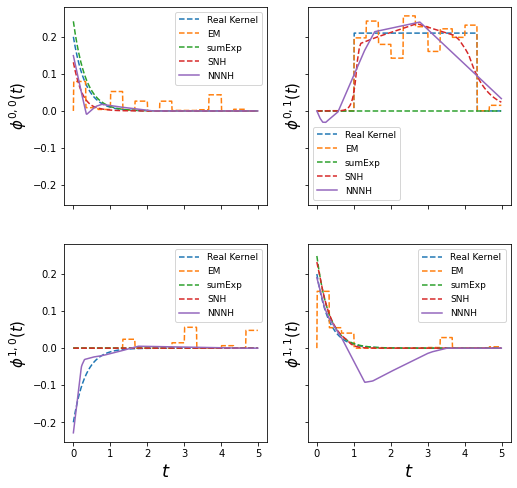

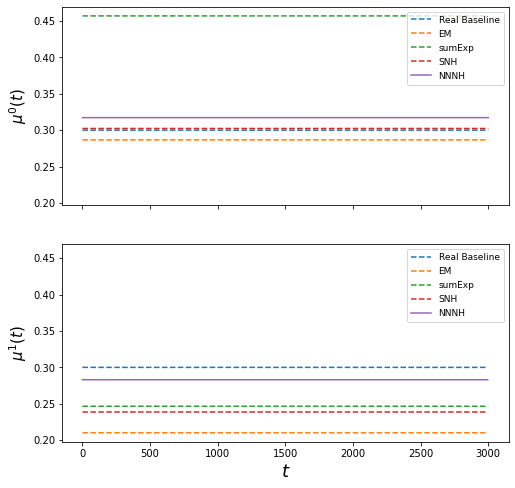

In [39]:
#get node
c_nodes = totalD

#tk
dx=0.01
tk = np.arange(0,5,dx)
y2 = np.zeros([len(tk),4])
interval1=np.arange(0,2,100)
bl=learner.baseline[0,[interval1]]


#plot
fig, ax_list_list = plt.subplots(c_nodes,c_nodes, sharex=True,
                                         sharey=True,figsize=(8, 8))
    

for i, ax_list in enumerate(ax_list_list):
    for j, ax in enumerate(ax_list):
        realKernel= plottingKernels(i,j,tk)
        ax.plot(tk, realKernel,'--', label="Real Kernel")
        y_values = em.get_kernel_values(i, j, tk)
        ax.plot(tk, y_values,'--', label="EM")
        y_values=learner.get_kernel_values(i,j,tk)
        ax.plot(tk, y_values,'--', label="sumExp")
        y_values = (sm.optimalKernel(i, j, tk))
        ax.plot(tk, y_values.reshape(-1),'--', label="SNH")
        y_values = optimalKernel(i, j, tk)
        ax.plot(tk, y_values.reshape(-1), label="NNNH")
        
  
        
        # set x_label for last line
        if i == c_nodes - 1:
            ax.set_xlabel(r"$t$", fontsize=18)

        ax.set_ylabel(r"$\phi^{%g,%g}(t)$" % (i, j), fontsize=15)
        
        legend = ax.legend()
        for label in legend.get_texts():
            label.set_fontsize(9)
plt.savefig('results_MSNH/2dcntMuKernel.png',dpi=300)
plt.pause(0.005)
plt.show()

fig, ax_list_list = plt.subplots(c_nodes, sharex=True,
                                         sharey=True,figsize=(8, 8))
for i, ax in enumerate(ax_list_list):
    
    tk=np.arange(0,int(t[i][-1]),1)
 
    realMu= mu[i]*np.ones(len(tk))
    ax.plot(tk, realMu,'--', label="Real Baseline")
    y_values = em.baseline[i]*np.ones(len(tk))
    ax.plot(tk, y_values,'--', label="EM")
    y_values=learner.baseline[i][0]*np.ones(len(tk))
    ax.plot(tk, y_values,'--', label="sumExp")
    y_values = (snhoptimal[0][4][i])*np.ones(len(tk))
    ax.plot(tk, y_values,'--', label="SNH")
    y_values = (optimalMu(i, tk)).reshape(-1)
    ax.plot(tk, y_values, label="NNNH")
        
  
        
    # set x_label for last line
    if i == c_nodes - 1:
        ax.set_xlabel(r"$t$", fontsize=18)

    ax.set_ylabel(r"$\mu^{%g}(t)$" % (i), fontsize=15)
        
    legend = ax.legend()
    for label in legend.get_texts():
        label.set_fontsize(9)
plt.savefig('results_MSNH/2dcntMuMu.png',dpi=300)
plt.pause(0.005)
plt.show()


In [34]:
def customIntegrateKernelEM(tend,m,n):
    dx=0.001
    tk = np.arange(0,5,dx)
    t2 = np.unique(np.concatenate([tend, tk]))
    t3 = np.sort(t2)
    dx = np.diff(t3)
    
    ytemp = em.get_kernel_values(m,n,t3).reshape(-1)
    yTrap= 0.5*(ytemp[0:-1]+ytemp[1:])
    
    a = np.multiply(yTrap,dx)
    a1 = np.cumsum(np.concatenate([np.array([0]), a]).reshape(-1))
    b = a1[[np.where(t3 ==x)[0][0] for x in tend]]
    return b

def EM_Neg_ll(baseline):
    
    T = max(t[0][-1],t[1][-1])
    ll=0
    for d in range(0,len(t),1):
        a=0
        for p in range(0,len(t),1):
            tend = (t[d][-1]-t[p][:])
            a+= np.sum(customIntegrateKernelEM(tend.reshape(-1),d,p))
    
        ll = ll+ mu[d]*T+a
        ll = ll-np.log(mu[d])
        llinit = ll
        td = t[d][:]  
        for i in range(1,len(td),1):
            li = max(i-20,0)
            temp1 = td[i]-td[li:i]
            decayFactor = (em.get_kernel_values(d,d, temp1)).sum()
            for p in dictdimP[d]: 
                jT = mapping[d,p].get(td[i])
                if(jT != None):
                    j = jT
                    lj = max(j-20,0)
                    temp2 = td[i]-t[p][lj:j+1]
                    decayFactor = decayFactor + np.sum(em.get_kernel_values(d,p,temp2))
                    logLam = -np.log(baseline[d]+decayFactor)
                    ll = ll+logLam
    return ll


def customIntegrateKernelSumExp(tend,m,n):
    dx=0.001
    tk = np.arange(0,5,dx)
    t2 = np.unique(np.concatenate([tend, tk]))
    t3 = np.sort(t2)
    dx = np.diff(t3)
    
    ytemp = learner.get_kernel_values(m,n,t3).reshape(-1)
    yTrap= 0.5*(ytemp[0:-1]+ytemp[1:])
    
    a = np.multiply(yTrap,dx)
    a1 = np.cumsum(np.concatenate([np.array([0]), a]).reshape(-1))
    b = a1[[np.where(t3 ==x)[0][0] for x in tend]]
    return b

def SumExp_Neg_ll(baseline):
    
    T = max(t[0][-1],t[1][-1])
    ll=0
    for d in range(0,len(t),1):
        a=0
        for p in range(0,len(t),1):
            tend = (t[d][-1]-t[p][:])
            a+= np.sum(customIntegrateKernelSumExp(tend.reshape(-1),d,p))
    
        ll = ll+ mu[d]*T+a
        ll = ll-np.log(mu[d])
        llinit = ll
        td = t[d][:]  
        for i in range(1,len(td),1):
            li = max(i-20,0)
            temp1 = td[i]-td[li:i]
            decayFactor = (learner.get_kernel_values(d,d, temp1)).sum()
            for p in dictdimP[d]: 
                jT = mapping[d,p].get(td[i])
                if(jT != None):
                    j = jT
                    lj = max(j-20,0)
                    temp2 = td[i]-t[p][lj:j+1]
                    decayFactor = decayFactor + np.sum(learner.get_kernel_values(d,p,temp2))
                    logLam = -np.log(baseline[d]+decayFactor)
                    ll = ll+logLam
    return ll


print("likelihood EM",EM_Neg_ll(em.baseline))
print("likelihood SumExp",SumExp_Neg_ll(learner.baseline[:,0]))
print("likelihood SNH",snhoptimal[2])
print("likelihood NNNH",SGDNNH[2])

likelihood EM 4638.912573941539
likelihood SumExp 4055.2887429950856
likelihood SNH 4263.027411043399
likelihood NNNH 4228.873981866675


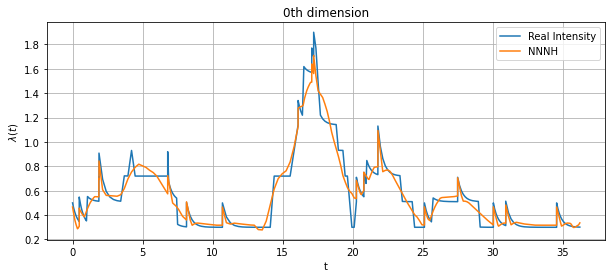

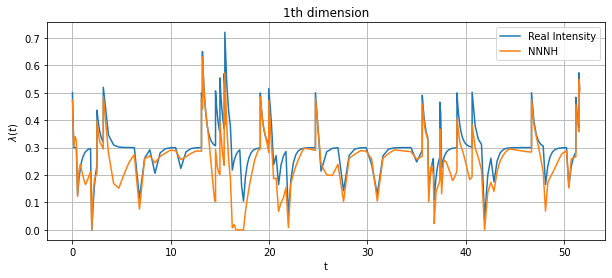

In [37]:
def plotLambdas():
    
    plotrange=20
    dx=0.01

    for p in range(totalD):
        c=musC[:,p]
        tp=t[p]
        lambda_value=[]
        time_intervals=[]
        lambda_nn=[]
        for j in range(1,plotrange):
            
            
            new_temp=np.linspace(tp[j-1],tp[j],20)
            decayfactor=np.zeros(len(new_temp))
            decayfactornn=np.zeros(len(new_temp))
            li=max(0,j-support)
            temp=new_temp.reshape(-1,1)-tp[li:j]
            
            for k1 in range(len(temp)):
                decayfactor[k1]+=np.sum(plottingKernels(p,p,temp[k1]))
                decayfactornn[k1]+=np.sum(optimalKernel(p,p,temp[k1]))
            for k in  dictdimP[p]:
                jt=mapping[p,k].get(tp[j])
                if jt!=None:
                    ti=max(0,jt-support)
                    temp2=new_temp.reshape(-1,1)-t[k][ti:jt+1]
                    
                    for k1 in range(len(temp2)):
                        temp2s=temp2[k1][temp2[k1]>0]
                        decayfactor[k1]+=np.sum(plottingKernels(p,k,temp2s))
                        decayfactornn[k1]+=np.sum(optimalKernel(p,k,temp2s))
                        
                    
            lambda1=np.maximum(mu[p]+decayfactor,0)
            lambdann1=np.maximum(optimalMu(p,new_temp)+decayfactornn,0)+c
            lambda_value.append(lambda1)
            lambda_nn.append(lambdann1)
            time_intervals.append(new_temp)
        time_intervals=(np.array(time_intervals)).reshape(-1)
        lambda_value=(np.array(lambda_value)).reshape(-1)
        lambda_nn=(np.array(lambda_nn)).reshape(-1)
        plt.figure(figsize=(10,4))
        plt.title(str(p)+"th dimension")
        
        plt.plot(time_intervals,lambda_value,label="Real Intensity")
        plt.plot(time_intervals,lambda_nn,label="NNNH")
        plt.xlabel("t")
        plt.ylabel("$\lambda(t)$")
        plt.legend()
        plt.grid()
        plt.savefig('results_MSNH/2dcntMulambdas_%g.png' % (p),dpi=200)
        plt.pause(0.005)
    return
plotLambdas()
file2 = open(r"results_MSNH/2dcntMu.txt","w+")

for j in range(len(SGDNNH)-1):
    file2.write("nextline\n" )
    for k in range(len(SGDNNH[j])):    
        file2.write("%s\n" %SGDNNH[j][k])
file2.close()